# Mapping public green areas in Manchester with geopandas

## Context & aim

The benefits of having public green areas around when living in a densily populated city are many, from encouraging exercise or providing spaces for socializing to decreasing noise and air pollution.  

I aim to map public green areas in Manchester and how they distribute accroding to it population. Fields in Trust have done an amazing job at mapping the whole of the UK and stablishing their [green-space-index](https://www.fieldsintrust.org/green-space-index), but I aim to have my own go at it using python and geopandas.

Let's import the main libraries that we are going to need.

In [168]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import contextily as cx # map backgrounds

## Greater Manchester Boundaries

Alright. The first thing we need to do is define what the boundaries fo Manchester are. For this, I am going to use shape files that delimit district boundaries provided by [Ordenance and Survey](https://osdatahub.os.uk/downloads/open/BoundaryLine). I have downloaded the file and used Geopandas to read it from the local file.

In [169]:
# Load boundaries from local shape file
fp = 'data/boundary_lines/district_borough_unitary_region.shp'
df = gpd.read_file(fp)

Geopandas is an open source python library that aims to simplfy geospatial data anlaysis. Geopandas is built on top of Pandas, therefore all regular pandas functionalities are included in the package. The library uses [shapely](https://github.com/Toblerity/Shapely) to perform a wide range of geometric operations, like overlay analysis, geocoding, spatial aggregation methods and spatial joins that are handy GIS-functionalities. It relies on [fiona](https://github.com/Toblerity/Fiona) for file access, being able to read most vector-based spatial data format (like ESRI shapefile or GeoJSON files), and on [matplotlib](https://matplotlib.org/) for plotting. 

`df` is now a GeoDataFrame object. Note that it looks very much like a rgeular pandas DataFrame with the addition of a `geometry` column. 

In [170]:
df.head(3)

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Buckinghamshire,UTA,Unitary Authority,BUCKINGHAMSHIRE,1,1,136198,176443,E06000060,156494.914,0.000,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((503946.104 190047.399, 503948.998 19..."
1,Dorset,UTA,Unitary Authority,DORSET,2,2,135743,175988,E06000059,252107.436,3011.777,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((403126.502 121160.497, 403120.302 12..."
2,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,0.000,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((366280.602 414615.697, 366295.699 41..."


This file includes all boundaries for Great Britain. We actually only need those of Manchester, so we will manually filter the areas that make Greater Manchester Combined Authority. Note that filtering a Geopandas dataframe works the same way as filtering a Pandas dataframe.

In [171]:
greater_manchester_districts = [
    'Manchester District (B)',
    'Bury District (B)',
    'Oldham District (B)',
    'Rochdale District (B)',
    'Salford District (B)',
    'Trafford District (B)',
    'Stockport District (B)',
    'Tameside District (B)',
    'Bolton District (B)',
    'Wigan District (B)',
]

# Filtering to Greater Manchester
gmcr_boroughs = df[df['NAME'].isin(greater_manchester_districts)]

The pseudo-mercator coordinate system is the coordinate system commonly used for rendering maps in platforms like Google Maps and OpenStreetMaps. `contextily`, which I will use to add backgrounds to maps, uses this coordinate system and therefore I need to convert my geopandas to pseudo-mercator. Luckily, doing this in geopandas is really easy.

In [172]:
gmcr_boroughs.to_crs(epsg=3857, inplace=True)

/home/neperiana/.local/share/virtualenvs/mapping_urban_green_areas-t-ZFWFtm/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


A plotting method is available as part of any GeoDataFrame.

<AxesSubplot:>

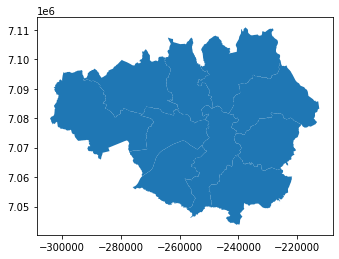

In [173]:
gmcr_boroughs.plot()

To ease some geographical operations later on, we are going to union all these district to create one unique *shape* for Greater Manchester. We will use `shapely.ops.cascade_union` operator for this.

In [174]:
from shapely.ops import cascaded_union

# Define Greater Manchester
greater_manchester = gpd.GeoSeries(cascaded_union(gmcr_boroughs.geometry))
greater_manchester.set_crs(epsg=3857, inplace=True)

0    POLYGON ((-225561.883 7062907.534, -225555.677...
dtype: geometry

## Green Areas in Greater Manchester

Now let's bring in the shape files denoting green areas. I will use the information provided by [Ordenance Survey's green space vector data](https://www.ordnancesurvey.co.uk/business-government/products/open-map-greenspace). I have downloaded sectors SD and SJ, which cover the whole of Greater Manchester. I use `GeoPandas.read_file()` to read them as GeoDataFrames and the usual `pandas.concat()` to concatenate both frames.

In [175]:
fp = 'data/greenspace_SD/SD_GreenspaceSite.shp'
gs_sd = gpd.read_file(fp)

fp = 'data/greenspace_SJ/SJ_GreenspaceSite.shp'
gs_sj = gpd.read_file(fp)

gs = gpd.GeoDataFrame(
    pd.concat([gs_sd, gs_sj], ignore_index=True)
)

This data contains different types of spaces categorised as green. I will only keep those that are not sport specific or religious, as those would be the areas accessible to all. 

In [176]:
# Green spaces areas bu function
gs.function.value_counts()

Play Space                                4344
Playing Field                             2763
Religious Grounds                         2650
Other Sports Facility                     2126
Public Park Or Garden                     1725
Bowling Green                             1438
Allotments Or Community Growing Spaces    1395
Cemetery                                   680
Tennis Court                               659
Golf Course                                394
Name: function, dtype: int64

In [177]:
# Keeping parcs
function_types = [
    'Play Space',
    'Playing Field',
    'Public Park Or Garden',
    'Bowling Green',
    'Allotments Or Community Growing Spaces',
]
gs = gs[gs['function'].isin(function_types)]

Again, everything needs to be in the same coordinate system, so we will convert these shapes to pseudo-mercator.

In [178]:
gs.to_crs(epsg=3857, inplace=True)

And let's only keep those that overlap with the boundaries of Greater Manchester using `Geopandas.overlay()` function.

In [179]:
# Filtering down to green spaces in greater manchester
gmcr_gs = gpd.overlay(mcr_boroughs, gs, how='intersection')

Again, plotting these shapes is as easy as calling the `geopandas.plot` method.

<AxesSubplot:>

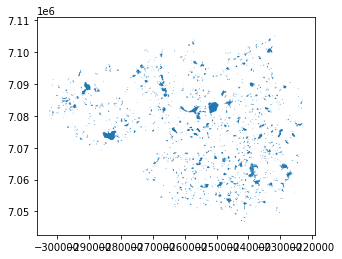

In [180]:
gmcr_gs.plot()

Let's plot it nicely, using `contextily` to add a nice open-street background map.

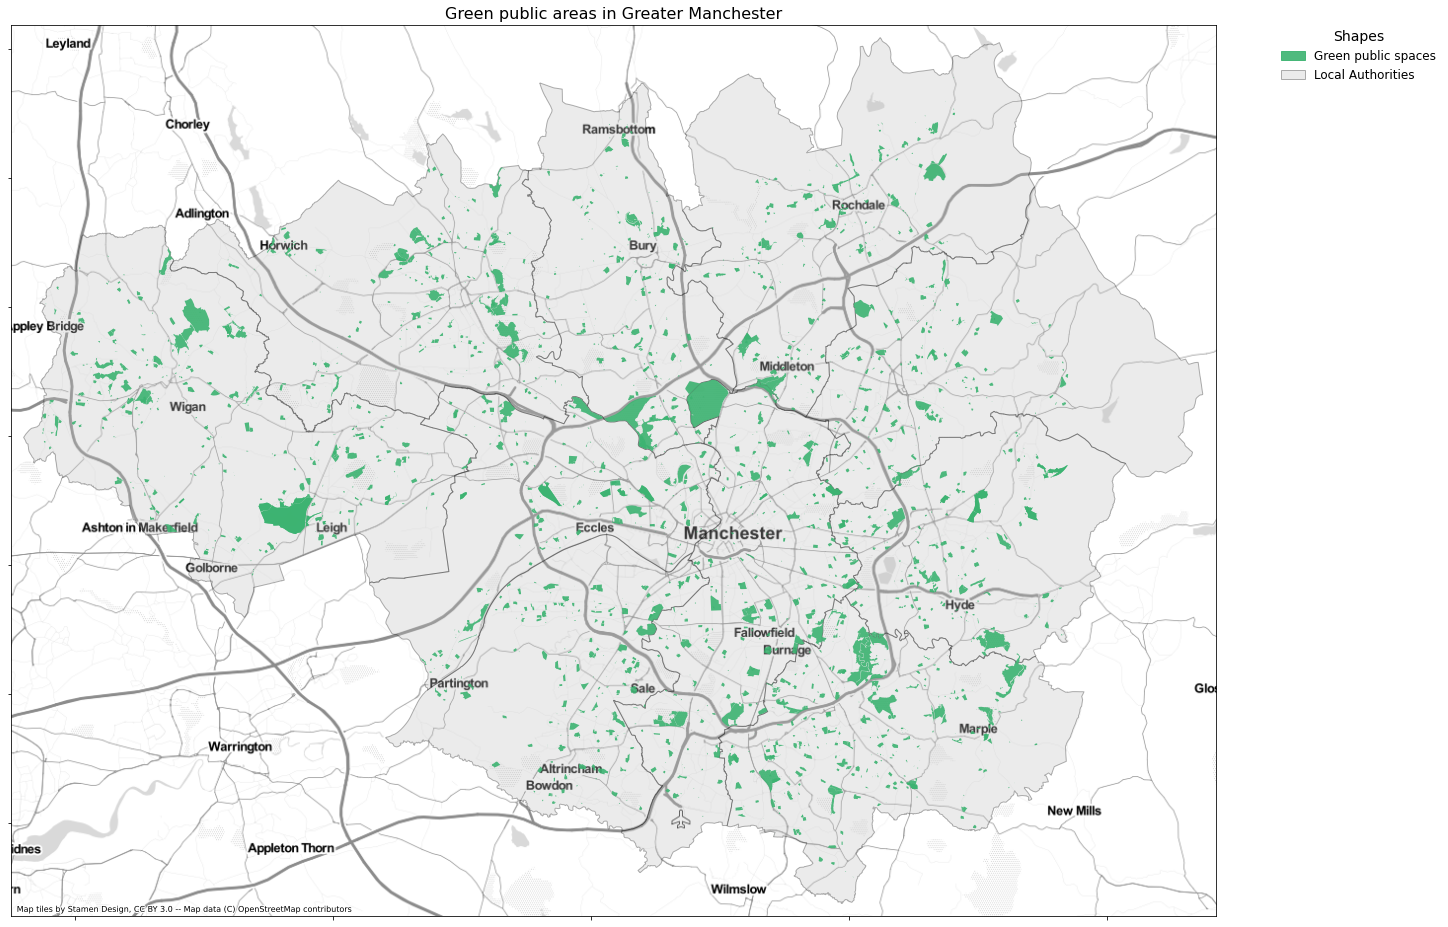

In [181]:
fig, ax = plt.subplots(figsize=(20,15))

# Define bounding box
bounds = greater_manchester.bounds
bounding_box = [
    bounds['minx'][0],
    bounds['maxx'][0],
    bounds['miny'][0],
    bounds['maxy'][0],
]

# Set bounds
ax.set_xlim(bounding_box[0]-1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2]-1000, bounding_box[3] + 1000)

# Plot borough borders
gmcr_boroughs.plot(
    ax=ax, 
    alpha=0.3, 
    edgecolor='black', 
    facecolor='silver',
)

# Plot green areas
gmcr_gs.plot(
    ax=ax, 
    alpha = 0.9, 
    color='mediumseagreen',
    label='Green Open Spaces',
)

# Add background
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

# Remove axis 
ax.set_yticklabels([])
ax.set_xticklabels([])

# Legend
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='mediumseagreen', alpha=0.9, label='Green public spaces')
gray_patch = mpatches.Patch(facecolor='silver', edgecolor='black', alpha=0.3, label='Local Authorities')
leg = plt.legend(
    handles=[green_patch, gray_patch],
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.,
    frameon=False,
    prop={'size': 12},
)
leg.set_title('Shapes', prop={'size':14})

plt.title('Green public areas in Greater Manchester', size=16)
plt.tight_layout()
plt.savefig('output/gmcr_green_areas.png')
plt.show()

Let's zoom in to Manchester city.

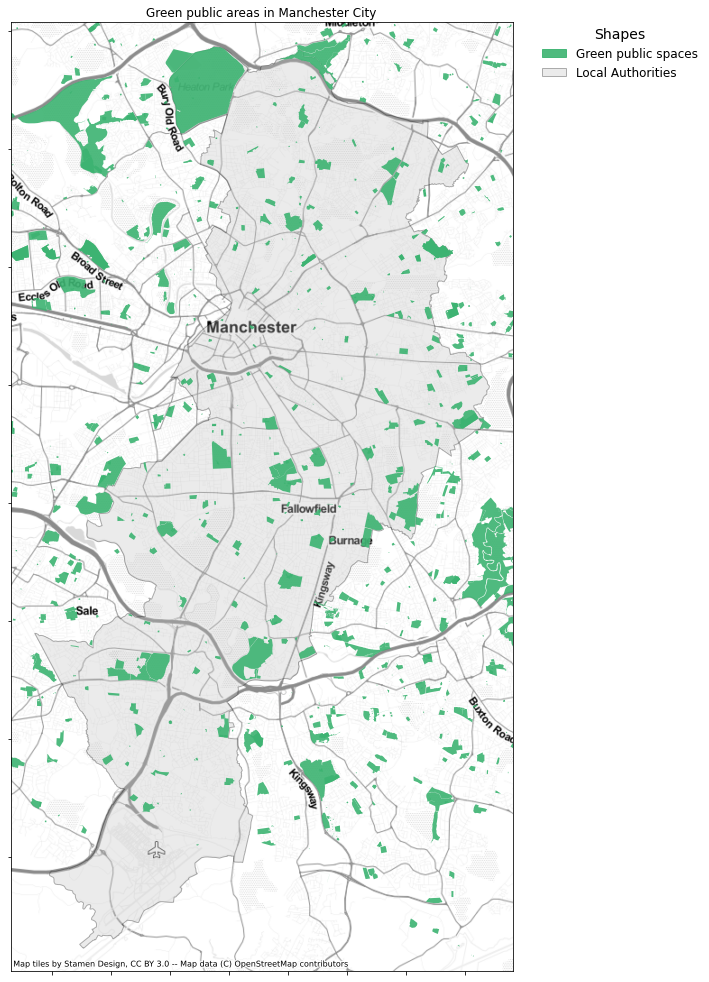

In [182]:
fig, ax = plt.subplots(figsize=(10,20))

# Define bounding box
mcr_city = gmcr_boroughs[gmcr_boroughs['NAME'] == 'Manchester District (B)']
bounds = mcr_city.bounds
bounding_box = [
    bounds['minx'].iloc[0],
    bounds['maxx'].iloc[0],
    bounds['miny'].iloc[0],
    bounds['maxy'].iloc[0],
]

# Set bounds
ax.set_xlim(bounding_box[0]-1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2]-1000, bounding_box[3] + 1000)

# Plot borough borders
mcr_city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="silver")

# Plot green areas
gmcr_gs.plot(ax=ax, alpha = 0.9, color="mediumseagreen")

# Add background
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

# Remove axis 
ax.set_yticklabels([])
ax.set_xticklabels([])

# Legend
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='mediumseagreen', alpha=0.9, label='Green public spaces')
gray_patch = mpatches.Patch(facecolor='silver', edgecolor='black', alpha=0.3, label='Local Authorities')
leg = plt.legend(
    handles=[green_patch, gray_patch],
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.,
    frameon=False,
    prop={'size': 12},
)
leg.set_title('Shapes', prop={'size':14})

plt.title('Green public areas in Manchester City')
plt.tight_layout()
plt.savefig('output/mcr_green_areas.png')
plt.show()

It's straight forward to see that the center of Manchester City Council lacks public green spaces, specially when compared to other districts nearby. But let's quantify this.

## Available public green space by postcode area

In order to quantify access to green spaces at the lowest possible granularity, I will be using postal sector granularity (so, postal codes expect the latest two letters, like *M1 2*). Data has been compiles and shared by the [Edinburgh Data Share](https://datashare.ed.ac.uk/handle/10283/2597). Again, using geopandas to read the shape file and converting to pseudo-mercator projection.

In [183]:
# UK Postal Sector boundaries
fp = 'data/GB_Postcodes/PostalSector.shp'
ps = gpd.read_file(fp)
ps.to_crs(epsg=3857, inplace=True)

In [184]:
ps.head(3)

,SectID,RMSect,GISSect,StrSect,PostDist,PostArea,DistNum,SecNum,PCCnt,AnomCnt,RefPC,x,y,Sprawl,Locale,geometry
0,1,AB10 1,AB10 1,AB101,AB10,AB,10,1,266,0,AB101TH,393574,806073,Aberdeen,None,"POLYGON ((-236435.656 7789683.265, -236369.417..."
1,2,AB10 6,AB10 6,AB106,AB10,AB,10,6,243,3,AB106PS,392796,805097,Aberdeen,None,"POLYGON ((-237577.490 7787513.676, -237577.142..."
2,3,AB10 7,AB10 7,AB107,AB10,AB,10,7,216,0,AB107DS,392056,803758,Aberdeen,None,"POLYGON ((-239174.406 7785151.834, -239045.817..."


Similarly to what I did with green spaces, let's use `geopandas.overlay()` function to only keep those postal sectors that belong to Greater Manchester.

In [185]:
# Filter by postal sectors in greater manchester
gmcr_ps = gpd.overlay(gmcr_boroughs, ps, how='intersection')

As we can observe when plotting, postal sector areas are smaller than the previously used local authority shapes.

<AxesSubplot:>

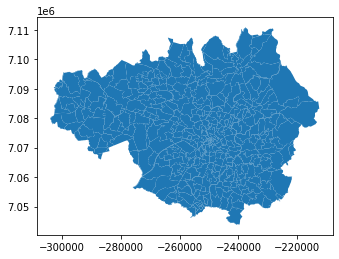

In [186]:
gmcr_ps.plot()

We want to calculate the amount of green spaces within a 10 minutes walk form each postal district. Why 10 minutes? As the people from [Fields in Trust](https://www.fieldsintrust.org/news/the-ten-minute-walk-and-why-its-important) brilliantly explain, a ten-minute walking distance is a well-established measure of an acceptable distance for a resident to be from their nearest park or green space. To make things easier, I will use the equivalent distance of a 10 minutes walk, which is roughly equivalent to 800 meters ([Wikipedia: 10 min walk](https://en.wikipedia.org/wiki/10-Minute_Walk)).

Firstly, let's copy our GeoDataFrame, as we will need the actual postal sector boundaries as they are later on.

In [187]:
gmcr_expanded_ps = gmcr_ps.copy()

Now let's use `shapely.buffer()` to expand out our geometry boundaries 800 meters.

In [188]:
gmcr_expanded_ps['geometry'] = gmcr_expanded_ps['geometry'].apply(lambda geo: geo.buffer(800))

`shapely` calculates distance in a Euclidean manner, using the good old Pythagoras’s theorem. This is not a big problem if our analysis uses a projection that preserves areas, unlike Mercator. I will use the Equal-Area Scalable Earth Grid (EASE-Grid), `epsg=6933`.

In [191]:
gmcr_expanded_ps.to_crs(epsg=6933, inplace=True)
mcr_gs_ease = gmcr_gs.copy()
mcr_gs_ease.to_crs(epsg=6933, inplace=True)

Let's loop over each expanded postal sector and calculate the intersection of our expanded boundary with all green areas within Greater Manchester. We can use `shapely.intersection` method to obtain the intersection between two polygons. We can then access the area of the resulting polygon by accessing the public `area` property.

In [192]:
gmcr_expanded_ps['green_area_sq_km'] = 0.0

for i, postal_sectors in gmcr_expanded_ps.iterrows():
    for j, green_space in enumerate(mcr_gs_ease['geometry']):
        green_area_in_postal_sector = postal_sectors['geometry'].intersection(green_space)
        gmcr_expanded_ps.at[i, 'green_area_sq_km'] += green_area_in_postal_sector.area / 10**6 # squared km

In [193]:
gmcr_expanded_ps = gmcr_expanded_ps[['RMSect','green_area_sq_km']]

In [194]:
gmcr_expanded_ps['green_area_ha'] = gmcr_expanded_ps['green_area_sq_km'] * 100
gmcr_expanded_ps['green_area_sq_m'] = gmcr_expanded_ps['green_area_sq_km'] * 1000000

Let's peak on which postal sectors have walking access to the most green space:

In [195]:
gmcr_expanded_ps.sort_values(by='green_area_sq_km', ascending=False).head(10)


,RMSect,green_area_sq_km,green_area_ha,green_area_sq_m
397,WA3 1,4.682170,468.217003,4.682170e+06
428,WN7 4,4.344302,434.430191,4.344302e+06
111,M25 2,2.524224,252.422355,2.524224e+06
120,M45 7,2.464486,246.448642,2.464486e+06
450,SK5 7,2.163823,216.382328,2.163823e+06
452,SK5 8,2.114863,211.486293,2.114863e+06
427,WN7 3,2.040223,204.022343,2.040223e+06
74,WN2 1,2.036889,203.688900,2.036889e+06
72,WN1 2,1.978945,197.894503,1.978945e+06
106,M25 0,1.782119,178.211896,1.782119e+06


Excellent, let's merge these are calculations back to our original geodataframe.

In [196]:
gmcr_ps = pd.merge(
    gmcr_ps,
    gmcr_expanded_ps,
    how='left',
    on='RMSect',
)

Let's plot this information as a choropleth map.

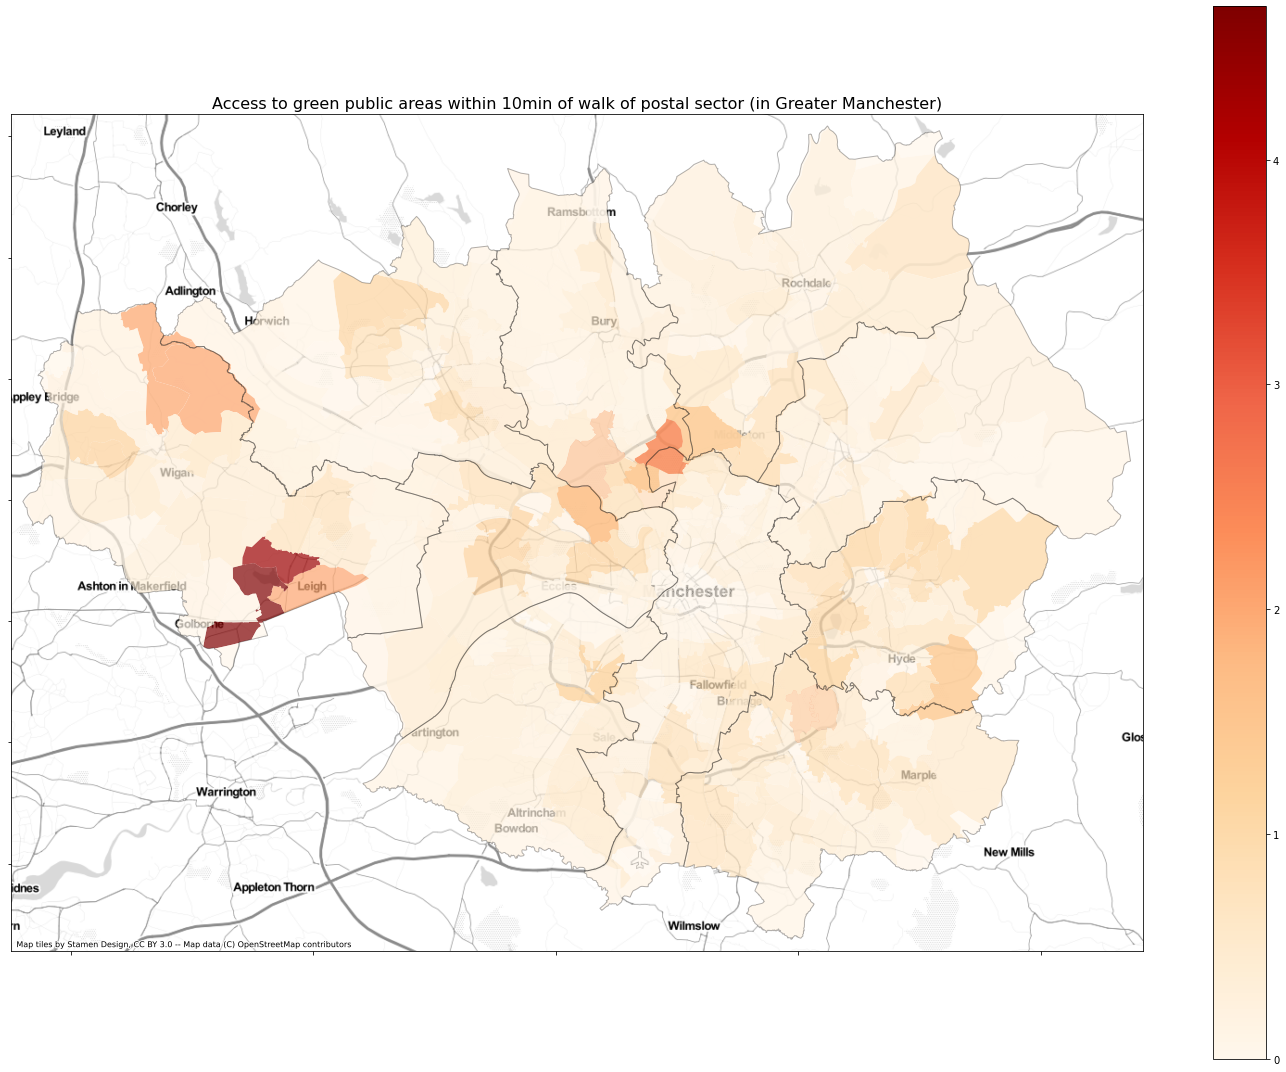

In [202]:
fig, ax = plt.subplots(figsize=(20,15))

# Define bounding box
bounds = greater_manchester.bounds
bounding_box = [
    bounds['minx'][0],
    bounds['maxx'][0],
    bounds['miny'][0],
    bounds['maxy'][0],
]

# Set bounds
ax.set_xlim(bounding_box[0]-1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2]-1000, bounding_box[3] + 1000)

# Plot green areas access
gmcr_ps.plot(ax=ax, column='green_area_sq_km', cmap='OrRd', alpha=0.7, legend=True)

# Plot borough borders
gmcr_boroughs.plot(ax=ax, alpha=0.3, edgecolor='black', facecolor='none')

# Add background
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

# Remove axis 
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.title('Access to green public areas within 10min of walk of postal sector (in Greater Manchester)', size=16)
plt.tight_layout()
plt.savefig('output/gmcr_green_areas_choropleth.png')
plt.show()

Acknowledgements:
* Contains OS data © Crown copyright and database right 2021.
* Postal Boundaries © GeoLytix copyright and database right 2012. 
  * Contains Ordenance Survey data © Crown copyright and database right 2012
  * Contains Royal Mail data © Royal Mail copyright and database right 2012 
  * Contains National Statistics data © Crown copyright and database right 2012. 
  * GIS vector data. This dataset was first accessioned in the EDINA ShareGeo Open repository on 2014-03-14 and migrated to Edinburgh DataShare on 2017-02-22.